# **In-Class Assignment: Topic Modeling**

## *IS 5150*
## Name: KEY

In the previous in-class assignment we went through different methods in key-phrase extraction. Both are relatively simple and easy to implement, but don't always yield the most useful information in regards to determining a document's overall theme/topic. Topic modeling is a more sophisticated approach to extracting topics/themes from a corpus, and there are several unsupervised approaches we can take to accomplishing this text mining task:



*   Latent Semantic Indexing
*   Latent Dirichlet Allocation

In this in-class assignment we will implement the above methods on a corpus of research papers from the NeurIPS conference to try and extract meaningful topic labels for these papers. We will begin with our oldest and most basic method, LSI and then end of NMF. Remember it's worth learning both newer and more traditional methods, because you never know which will perform best on any given task or dataset!


In [ ]:
# load all dependencies

import nltk
#nltk.download()  #stopwords, wordnet, omw-1.4
import gensim

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **1) Data Retrieval**

We will be downloading the dataset directly using the following commands:

In [ ]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz

--2022-09-10 18:40:30--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  16.4MB/s    in 0.7s    

2022-09-10 18:40:31 (16.4 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



#### **A) Data Extraction**

We need to uncompress this tgz file and extract the different text files within each of the subfolders, like so:

In [ ]:
!tar -xzf nips12raw_str602.tgz

In [ ]:
DATA_PATH = '/content/nipstxt'
print(os.listdir(DATA_PATH))

['nips05', 'idx', 'nips09', 'MATLAB_NOTES', 'orig', 'nips07', 'nips01', 'nips10', 'nips12', 'nips11', 'README_yann', 'nips02', 'nips03', 'nips06', 'nips04', 'nips00', 'RAW_DATA_NOTES', 'nips08']


In [ ]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + '/' + folder )
    for file_name in file_names:
        with open(DATA_PATH + '/' + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)

1740

**If using Jupyter notebooks/labs using this instead**

In [ ]:
"""
folders = ["nips{0:02}".format(i) for i in range(0,13)]
# Read all texts into a list.
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)
len(papers)
"""

'\nfolders = ["nips{0:02}".format(i) for i in range(0,13)]\n# Read all texts into a list.\npapers = []\nfor folder in folders:\n    file_names = os.listdir(DATA_PATH + folder)\n    for file_name in file_names:\n        with open(DATA_PATH + folder + \'/\' + file_name, encoding=\'utf-8\', errors=\'ignore\', mode=\'r+\') as f:\n            data = f.read()\n        papers.append(data)\nlen(papers)\n'

In [ ]:
print(papers[0][:1000])

387 
Neural Net and Traditional Classifiers  
William Y. Huang and Richard P. Lippmann 
MIT Lincoln Laboratory 
Lexington, MA 02173, USA 
Abstract
Previous work on nets with continuous-valued inputs led to generative 
procedures to construct convex decision regions with two-layer percepttons (one hidden 
layer) and arbitrary decision regions with three-layer percepttons (two hidden layers). 
Here we demonstrate that two-layer perceptton classifiers trained with back propagation 
can form both convex and disjoint decision regions. Such classifiers are robust, train 
rapidly, and provide good performance with simple decision regions. When complex 
decision regions are required, however, convergence time can be excessively long and 
performance is often no better than that of k-nearest neighbor classifiers. Three neural 
net classifiers are presented that provide more rapid training under such situations. 
Two use fixed weights in the first one or two layers and are similar to classifier

## **2) Basic Text Preprocessing**

We will do a separate normalize_corpus function here, because we don't need to do all the steps we normally would. This is going to save us some time in its execution.

In [ ]:
%%time

stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in papers:
        paper = paper.lower() # set paper to lowercase
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)] # tokenize paper and strip extra whitespaces
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]  # lemmatize tokens
        paper_tokens = [token for token in paper_tokens if len(token) > 1] # remove tokens shorter than 1 character or shorter
        paper_tokens = [token for token in paper_tokens if token not in stop_words] # remove stopwords
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740
CPU times: user 35.5 s, sys: 415 ms, total: 35.9 s
Wall time: 37.1 s


In [ ]:
print(norm_papers[0][:50])

['neural', 'net', 'traditional', 'classifier', 'william', 'huang', 'richard', 'lippmann', 'mit', 'lincoln', 'laboratory', 'lexington', 'usa', 'abstract', 'previous', 'work', 'net', 'continuous', 'valued', 'input', 'led', 'generative', 'procedure', 'construct', 'convex', 'decision', 'region', 'two', 'layer', 'percepttons', 'one', 'hidden', 'layer', 'arbitrary', 'decision', 'region', 'three', 'layer', 'percepttons', 'two', 'hidden', 'layer', 'demonstrate', 'two', 'layer', 'perceptton', 'classifier', 'trained', 'back', 'propagation']


## 3) **Feature Engineering**

Before we perform any sort of vectorization, we're going to narrow down our pool of words to more common n-grams; specifically bigrams that have occurred in the text at least 20 times. This is going to cut down on the number of words we need to vectorize.

In [ ]:
len(set(norm_papers[2]))*1740                                                                               # ~ vocab size of corpus

1839180

In [ ]:
bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_')                     # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['neural_net', 'traditional', 'classifier', 'william', 'huang', 'richard_lippmann', 'mit', 'lincoln_laboratory', 'lexington', 'usa_abstract', 'previous_work', 'net', 'continuous_valued', 'input', 'led', 'generative', 'procedure', 'construct', 'convex', 'decision_region', 'two', 'layer', 'percepttons', 'one', 'hidden_layer', 'arbitrary', 'decision_region', 'three', 'layer', 'percepttons', 'two', 'hidden_layer', 'demonstrate', 'two', 'layer', 'perceptton', 'classifier', 'trained', 'back_propagation', 'form', 'convex', 'disjoint', 'decision_region', 'classifier', 'robust', 'train', 'rapidly', 'provide', 'good', 'performance']


> #### **A) Extract bigrams from full corpus to create a condensed vocab set of high frequency phrases**

In [ ]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)                                                   # Create a dictionary representation of the documents
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '1ooooo'), (1, '1st'), (2, '25oo'), (3, '2o00'), (4, '4ooo'), (5, '5oo'), (6, '64k'), (7, '7th'), (8, 'a2'), (9, 'aaditional'), (10, 'able'), (11, 'acase'), (12, 'adapting'), (13, 'addition'), (14, 'adjust')]
Total Vocabulary Size: 78892


> #### **B) Let's further prune down our vocab set by removing words that occur in fewer than 20 documents or more than 60% of documents** 

**What is the logic behind this step?**

We don't need to include very frequent or very infrequent words/bigrams; those typically don't add much value to the meaning of the text.

In [ ]:
dictionary.filter_extremes(no_below=20, no_above=0.60)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


> #### **C) Bag of Words Vectorization**

Great! Now we've got a much more reasonable vocab size, so that when we convert our words to sparse vectors we won't have so many dimensions. Let's create our bow corpus from our dictionary of bigrams.

In [ ]:
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(4, 1), (8, 1), (12, 1), (15, 1), (16, 1), (18, 3), (19, 1), (22, 2), (23, 1), (26, 1), (32, 1), (33, 1), (35, 1), (40, 2), (41, 1), (43, 1), (51, 2), (55, 2), (74, 2), (78, 1), (81, 1), (84, 2), (85, 2), (86, 1), (87, 3), (91, 1), (99, 2), (114, 4), (115, 2), (119, 1), (120, 3), (121, 1), (124, 4), (126, 1), (127, 1), (129, 2), (130, 1), (137, 1), (138, 1), (145, 1), (146, 1), (148, 1), (149, 1), (150, 16), (153, 2), (155, 1), (160, 1), (168, 8), (177, 1), (178, 12)]


**What does each tuple represent here?**

A word index and its frequency in document 01.

In [ ]:
print([(dictionary[idx], freq) for idx, freq in bow_corpus[1][:50]])

[('able', 1), ('adjusted', 1), ('along', 1), ('alternative', 1), ('american_institute', 1), ('another', 3), ('appeared', 1), ('arbitrary', 2), ('architecture', 1), ('assigned', 1), ('author', 1), ('automatically', 1), ('averaged', 1), ('behavior', 2), ('belong', 1), ('better', 1), ('brain', 2), ('called', 2), ('comparison', 2), ('computing', 1), ('conference', 1), ('connection', 2), ('considered', 2), ('consists', 1), ('construct', 3), ('context', 1), ('definition', 2), ('density', 1), ('department', 3), ('depends', 1), ('desired', 4), ('detail', 1), ('determine', 1), ('determined', 2), ('developed', 1), ('disjoint', 1), ('divide', 1), ('enough', 1), ('entire', 1), ('eq', 1), ('equal', 1), ('estimate', 2), ('except', 1), ('expressed', 1), ('finite', 1), ('fixed', 12), ('formed', 1), ('forming', 1), ('four', 3), ('furthermore', 1)]


## **4) Topic Modeling with Latent Semantic Indexing (LSI)**

We begin with using latent semantic indexing to generate a topic model, we will set our total number of topics to 10 and then examine which words are most influential for each topic.

In [ ]:
%%time
TOTAL_TOPICS = 10
lsi_bow = gensim.models.LsiModel(bow_corpus, id2word=dictionary, num_topics=TOTAL_TOPICS,
                                 onepass=True, chunksize=1740, power_iters=1000)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


> #### **A) Print topics (top 20 words per 10 topics)**

In [ ]:
for topic_id, topic in lsi_bow.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.241*"neuron" + 0.187*"image" + 0.169*"cell" + 0.132*"layer" + 0.116*"class" + 0.114*"signal" + 0.113*"response" + 0.107*"probability" + 0.100*"noise" + 0.099*"distribution" + 0.099*"node" + 0.099*"representation" + 0.097*"rule" + 0.093*"control" + 0.091*"rate" + 0.086*"stimulus" + 0.083*"sequence" + 0.082*"object" + 0.082*"architecture" + 0.082*"dynamic"

Topic #2:
0.534*"neuron" + 0.399*"cell" + 0.179*"response" + -0.167*"image" + 0.164*"stimulus" + -0.158*"class" + -0.118*"classifier" + 0.112*"activity" + 0.102*"spike" + 0.101*"synaptic" + -0.099*"node" + 0.094*"firing" + -0.093*"word" + 0.092*"circuit" + -0.090*"probability" + -0.085*"classification" + -0.079*"sample" + -0.078*"distribution" + 0.078*"cortical" + 0.077*"signal"

Topic #3:
0.721*"image" + 0.216*"object" + -0.203*"neuron" + 0.148*"cell" + 0.143*"visual" + 0.110*"pixel" + 0.107*"face" + 0.106*"motion" + -0.088*"rule" + 0.082*"response" + -0.080*"probability" + 0.078*"view" + -0.073*"node" + 0.073*"representa

**Like a correlation coefficient, the larger the associated weight, the stronger the influence of a word within a topic. But what does it mean for a topic to have words with positive and negative weights?**

Can indicate two distrinct sub-topics (two directions) within one topic.

In [ ]:
for n in range(TOTAL_TOPICS):
    print('Topic #'+str(n+1)+':')
    print('='*50)
    d1 = []
    d2 = []
    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    print('Direction 1:', d1)
    print('-'*50)
    print('Direction 2:', d2)
    print('-'*50)
    print()

Topic #1:
Direction 1: [('neuron', 0.241), ('image', 0.187), ('cell', 0.169), ('layer', 0.132), ('class', 0.116), ('signal', 0.114), ('response', 0.113), ('probability', 0.107), ('noise', 0.1), ('distribution', 0.099), ('node', 0.099), ('representation', 0.099), ('rule', 0.097), ('control', 0.093), ('rate', 0.091), ('stimulus', 0.086), ('sequence', 0.083), ('object', 0.082), ('architecture', 0.082), ('dynamic', 0.082)]
--------------------------------------------------
Direction 2: []
--------------------------------------------------

Topic #2:
Direction 1: [('neuron', 0.534), ('cell', 0.399), ('response', 0.179), ('stimulus', 0.164), ('activity', 0.112), ('spike', 0.102), ('synaptic', 0.101), ('firing', 0.094), ('circuit', 0.092), ('cortical', 0.078), ('signal', 0.077)]
--------------------------------------------------
Direction 2: [('image', -0.167), ('class', -0.158), ('classifier', -0.118), ('node', -0.099), ('word', -0.093), ('probability', -0.09), ('classification', -0.085), ('

**Spend some time examining the different words amongst topics 1-10 and their 2 subtopics; what are some themes/possible topics that emerge?**

Answer on own; topic 2 e.g., seems to be about neural activity and image classification

> #### **B) Apply SVD to decompose our term-document matrix into term-topic, topic-topic, and topic-documnet matrices**

In [ ]:
term_topic = lsi_bow.projection.u
singular_values = lsi_bow.projection.s
topic_document = (gensim.matutils.corpus2dense(lsi_bow[bow_corpus], len(singular_values)).T / singular_values).T
term_topic.shape, singular_values.shape, topic_document.shape

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


((7706, 10), (10,), (10, 1740))

> #### **C) Transpose to Document Topic Matrix**

In [ ]:
document_topics = pd.DataFrame(np.round(topic_document.T, 3), 
                               columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])
document_topics.head(15)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
0,0.041,-0.039,-0.018,0.002,-0.134,-0.038,-0.108,0.121,0.009,0.088
1,0.027,-0.012,-0.021,-0.001,0.001,0.015,-0.026,-0.015,-0.009,0.006
2,0.033,-0.018,-0.003,0.011,0.001,0.032,-0.012,-0.012,-0.017,0.010
3,0.032,0.030,-0.029,-0.054,-0.007,0.001,-0.013,-0.028,0.007,-0.025
4,0.025,-0.003,-0.016,-0.013,0.023,-0.003,-0.002,0.009,-0.002,-0.017
5,0.016,0.004,-0.013,-0.015,0.009,0.003,-0.009,0.001,0.009,0.005
6,0.030,0.059,0.012,0.080,-0.019,-0.030,-0.014,-0.005,0.011,-0.014
7,0.039,-0.016,-0.030,0.000,-0.019,0.077,-0.044,-0.015,-0.030,0.002
8,0.022,0.027,-0.001,0.028,-0.008,-0.014,0.004,0.005,0.011,-0.013
9,0.020,0.002,-0.004,0.009,-0.009,-0.004,-0.016,-0.001,0.010,0.008


In [ ]:
document_numbers = [8, 150, 200]

for document_number in document_numbers:
    top_topics = list(document_topics.columns[np.argsort(-np.absolute(document_topics.iloc[document_number].values))[:3]])
    print('Document #'+str(document_number)+':')
    print('Dominant Topics (top 3):', top_topics)
    print('Paper Summary:')
    print(papers[document_number][:500])
    print()

Document #8:
Dominant Topics (top 3): ['T4', 'T2', 'T1']
Paper Summary:
242 
THE SIGMOID NONLINEARITY IN PREPYRIFORM CORTEX 
Frank H. Eeckman 
University of California, Berkeley, CA 94720 
ABSTRACT 
We report a study bn the relationship between EEG amplitude values and unit 
spike output in the prepyriform cortex of awake and motivated rats. This relationship 
takes the form of a sigmoid curve, that describes normalized pulse-output for 
normalized wave input. The curve is fitted using nonlinear regression and is 
described by its slope and maximum value. 
Measureme

Document #150:
Dominant Topics (top 3): ['T8', 'T4', 'T2']
Paper Summary:
695 
ANALOG IMPLEMENTATION OF SHUNTING 
NEURAL NETWORKS 
Bahram Nabet, Robert B. Darling, and Robert B. Pinter 
Department of Electrical Engineering, FT-10 
University of Washington 
Seattle, WA 98195 
ABSTRACT 
An extremely compact, all analog and fully parallel implementa- 
tion of a class of shunting recurrent neural networks that is ap- 
plicable

**Examine a sample of three different documents. Based on the information provided in our *document summary*, do the top 3 topics for each of these sampled documents make sense? Refer back to the list of top 20 words for each topic.**

## **5) Topic Modeling with Latent Dirichlet Allocation (LDA)**

In [ ]:
%%time
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: user 1min 36s, sys: 2.39 s, total: 1min 38s
Wall time: 1min 36s


> #### **A) Print topics, topics = 10**

In [ ]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.023*"neuron" + 0.020*"cell" + 0.009*"response" + 0.008*"activity" + 0.007*"stimulus" + 0.006*"synaptic" + 0.005*"circuit" + 0.005*"connection" + 0.004*"cortical" + 0.004*"firing" + 0.004*"layer" + 0.004*"synapsis" + 0.004*"spike" + 0.004*"voltage" + 0.004*"signal" + 0.004*"cortex" + 0.003*"simulation" + 0.003*"frequency" + 0.003*"chip" + 0.003*"mechanism"

Topic #2:
0.009*"distribution" + 0.008*"variable" + 0.007*"probability" + 0.006*"prior" + 0.006*"gaussian" + 0.006*"estimate" + 0.006*"mixture" + 0.005*"approximation" + 0.005*"density" + 0.005*"bayesian" + 0.004*"sample" + 0.004*"matrix" + 0.004*"likelihood" + 0.004*"estimation" + 0.004*"component" + 0.003*"log" + 0.003*"variance" + 0.003*"noise" + 0.003*"posterior" + 0.003*"em"

Topic #3:
0.012*"classifier" + 0.012*"class" + 0.010*"classification" + 0.006*"rule" + 0.005*"test" + 0.005*"kernel" + 0.004*"training_set" + 0.004*"tree" + 0.004*"prediction" + 0.004*"machine" + 0.003*"table" + 0.003*"probability" + 0.003*"repr

**What is a key difference in the weights produced using LSI vs LDA?**

LSI contain negative weights, LDA does not -- makes the LDA weights easier to interpret.

> #### **B) Topic Coherenence Scores**

Let's now get an idea of how our topic model is performing by computing the perplexity and the coherence scores ($C_v$ and UMass).

In [ ]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5024377489290612
Avg. Coherence Score (UMass): -1.1587366536698354
Model Perplexity: -7.861088487128816


> #### **C) (On your own) Try out a Different LDA Model Implementation from MALLET**

For the sake of time, try out a different LDA model implementation from a library called MALLET (MAchine Learning for LanguagE Toolkit) -- they really forced that acronym. It's worth exploring different pretrained models because different models will work better in different situations. Run through the provided code and report back on your findings.

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip            # download mallet zip file
!unzip -q mallet-2.0.8.zip                                        # unzip compressed files

--2022-09-10 18:38:39--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-09-10 18:38:39--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  16.7MB/s    in 0.9s    

2022-09-10 18:38:40 (16.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'                                                               # set path to mallet models
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus,             # set lda model parameters
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                              iterations=500, workers=16)

In [ ]:
topics = [[(term, round(wt, 3)) 
               for term, wt in lda_mallet.show_topic(n, topn=20)]                                     # save topics as list, round weights to 3 decimanls, top 20 words per topic
                   for n in range(0, TOTAL_TOPICS)]

for idx, topic in enumerate(topics):                                                                  # print each topic with their top 20 terms
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['training', 'class', 'classification', 'word', 'classifier', 'recognition', 'feature', 'pattern', 'vector', 'speech', 'trained', 'sequence', 'character', 'cluster', 'context', 'hmm', 'experiment', 'probability', 'test', 'rbf']

Topic #2:
['training', 'tree', 'test', 'experiment', 'search', 'prediction', 'size', 'table', 'graph', 'training_set', 'feature', 'node', 'technique', 'average', 'measure', 'random', 'machine', 'run', 'selection', 'instance']

Topic #3:
['dynamic', 'equation', 'state', 'memory', 'neuron', 'vector', 'pattern', 'matrix', 'solution', 'energy', 'phase', 'eq', 'noise', 'code', 'capacity', 'attractor', 'fig', 'correlation', 'fixed_point', 'rule']

Topic #4:
['signal', 'circuit', 'current', 'chip', 'neuron', 'analog', 'voltage', 'channel', 'noise', 'source', 'bit', 'neural', 'implementation', 'filter', 'design', 'processor', 'computation', 'frequency', 'gain', 'parallel']

Topic #5:
['linear', 'vector', 'class', 'convergence', 'bound', 'theorem', 'optimal', 

In [ ]:
cv_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                             texts=norm_corpus_bigrams,
                                                             dictionary=dictionary, 
                                                             coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models.CoherenceModel(model=lda_mallet, corpus=bow_corpus, 
                                                                texts=norm_corpus_bigrams,
                                                                dictionary=dictionary,  
                                                                coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533
print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.5031632844310924
Avg. Coherence Score (UMass): -1.070707076010317
Model Perplexity: -8.53533


**How do the metrics of topic model quality differ between the basic gensim implementation and the mallet implementation? Which model appeared to perform better in this case?**

## **6) Parameter Tuning a Topic Model**

Parameter tuning for an unsupervised text mining technique like topic modeling is a little odd, since we don't have direct evaluation metrics. But, we can use our topic coherence scores to try and find an optimal number of topics, where by we have the fewest topics (to maximize simplicity) for the highest coherence score (to maximize topic quality). We will examine this iteratively to determine the optimal number of topics; and will produce a visualization to help guide our conclusion.


In [ ]:
from tqdm import tqdm

In [ ]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [ ]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=10,
                                                               end_topic_count=12, step=1, cpus=2)

100%|██████████| 3/3 [09:06<00:00, 182.00s/it]


> #### **A) (On your own) Evaluate a larger number of topics**

Go back through the previous code on your own and train topic models on a larger range of topics to try and find an optimal amount. We examined a narrow range in class, so we may not have found the best number of topics. Running this will take some time, and the larger your range the more time it will take to run.

Report back below on what you found the best number of topics to be after rerunning this analysis.

> #### **B) Produce table of topic numbers by coherence scores; then plot**

In [ ]:
coherence_scores

[0.5260681844987625, 0.5164835418968532, 0.5213157294626155]

In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(10, 13, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head()

,Number of Topics,Coherence Score
0,10,0.5261
2,12,0.5213
1,11,0.5165


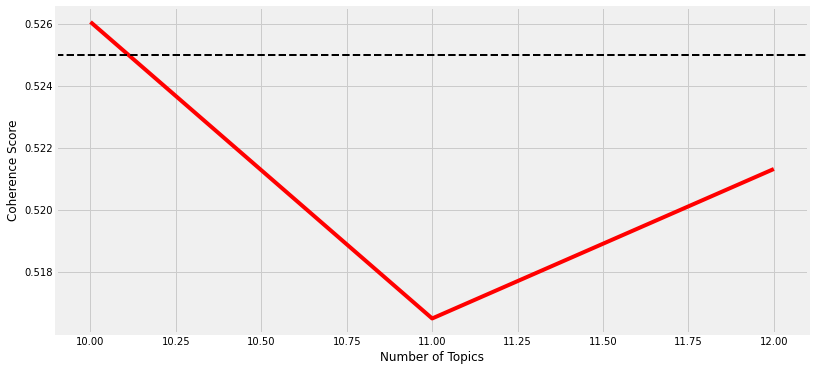

In [ ]:
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(10,13,1)                                                                   # Adjust the range based on the number/range of topics you chose
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.525, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

> #### **C) Determine the Optimal Number of Topics and then rerun model**

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 10].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

10

In [ ]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]
'''
for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()
'''

> #### **D) Display as Term-Topic Dataframe**

In [ ]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"training, classification, word, class, trained, classifier, feature, recognition, test, task, training_set, pattern, experiment, table, speech, character, accuracy, test_set, vector, technique"
Topic2,"equation, vector, matrix, solution, dynamic, linear, rate, noise, training, gradient, convergence, nonlinear, eq, optimal, average, minimum, optimization, curve, line, constraint"
Topic3,"class, bound, size, theorem, probability, linear, theory, complexity, defined, approximation, define, threshold, loss, xi, proof, hypothesis, section, assume, polynomial, concept"
Topic4,"signal, noise, filter, source, frequency, response, subject, component, target, channel, human, temporal, rate, detection, correlation, study, task, stimulus, sound, effect"
Topic5,"image, feature, object, motion, map, visual, local, direction, pixel, position, region, location, representation, distance, field, view, face, surface, edge, vector"
Topic6,"neuron, circuit, current, chip, analog, voltage, bit, implementation, neural, design, parallel, computation, processor, operation, element, gain, synapse, application, array, device"
Topic7,"unit, pattern, rule, layer, node, hidden_unit, state, activation, net, sequence, memory, representation, structure, architecture, recurrent, connection, module, vector, level, connectionist"
Topic8,"distribution, estimate, variable, probability, gaussian, prior, sample, mixture, density, prediction, estimation, approximation, variance, bayesian, component, likelihood, regression, procedure, log, step"
Topic9,"state, control, action, step, task, trajectory, policy, environment, controller, optimal, reinforcement_learning, path, goal, search, robot, position, dynamic, move, current, change"
Topic10,"neuron, cell, response, activity, stimulus, pattern, spike, synaptic, neural, cortical, et_al, connection, firing, effect, cortex, visual, mechanism, simulation, layer, receptive_field"


> #### **E) Topic Model Interpretation**

One meaningful way we can interpret our topic models is to see what the most dominant (highest weighted) topics were in specific research papers. Let's create a dataframe containing the documet number, its most dominant topic number, the % contribution of that topic, the topic description and a exerpt from the beginning of the paper.

In [ ]:
tm_results = best_lda_model[bow_corpus]                                                           # ~ 21 seconds to run

corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]

corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(papers))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Paper'] = papers

In [ ]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document']
                 .isin([682, 10, 392, 1622, 17, 
                        906, 1005, 503, 13, 736])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
10,10,7,29.74,"unit, pattern, rule, layer, node, hidden_unit, state, activation, net, sequence, memory, representation, structure, architecture, recurrent, connection, module, vector, level, connectionist","233 \nHIGH ORDER NEURAL NETWORKS FOR EFFICIENT \nASSOCIATIVE MEMORY DESIGN \nI. GUYON*, L. PERSONNAZ*, J.P. NADAL** and G. DREYFUS* \n* Ecole SupOrieure de Physique et de Chimie Industrielles de l..."
13,13,6,68.42,"neuron, circuit, current, chip, analog, voltage, bit, implementation, neural, design, parallel, computation, processor, operation, element, gain, synapse, application, array, device","515 \nMICROELECTRONIC IMPLEMENTATIONS OF CONNECTIONIST \nNEURAL NETWORKS \nStuart Mackie, Hans P. Graf, Daniel B. Schwartz, and John S. Denker \nAT&T Bell Labs, Holmdel, NJ 07733 \nAbstract \nIn t..."
17,17,3,40.41,"class, bound, size, theorem, probability, linear, theory, complexity, defined, approximation, define, threshold, loss, xi, proof, hypothesis, section, assume, polynomial, concept","1 \nCONNECTIVITY VERSUS ENTROPY \nYaser S. Abu-Mostafa \nCalifornia Institute of Technology \nPasadena, CA 91125 \nABSTRACT \nHow does the connectivity of a neural network (number of synapses per ..."
392,392,9,21.74,"state, control, action, step, task, trajectory, policy, environment, controller, optimal, reinforcement_learning, path, goal, search, robot, position, dynamic, move, current, change","Modeling Time Varying Systems \nUsing Hidden Control Neural Architecture \nEsther Levin \nAT&T Bell Laboratories \nSpeech Research Department \nMurray Hill, NJ 07974 USA \nABSTRACT \nMulti-layered..."
503,503,5,38.31,"image, feature, object, motion, map, visual, local, direction, pixel, position, region, location, representation, distance, field, view, face, surface, edge, vector","Learning to Segment Images \nUsing Dynamic Feature Binding \nMichael C. Moser \nDept. of Comp. Science & \nInst. of Cognitive Science \nUniversity of Colorado \nBoulder, CO 80309-0430 \nRichard S...."
682,682,10,51.68,"neuron, cell, response, activity, stimulus, pattern, spike, synaptic, neural, cortical, et_al, connection, firing, effect, cortex, visual, mechanism, simulation, layer, receptive_field","Unsmearing Visual Motion: \nDevelopment of Long-Range \nHorizontal Intrinsic Connections \nKevin E. Martin Jonathan A. Marshall \nDepartment of Computer Science, CB 3175, Sitterson Hall \nUniversi..."
736,736,2,37.09,"equation, vector, matrix, solution, dynamic, linear, rate, noise, training, gradient, convergence, nonlinear, eq, optimal, average, minimum, optimization, curve, line, constraint","Optimality Criteria for LMS and \nBackpropagation \nBabak Hassibi \nInformation Systems Laboratory \nStanford University \nStanford, CA 94305 \nAll H. Sayed \nDept. of Elec. and Comp. Engr. \nUniv..."
906,906,5,55.13,"image, feature, object, motion, map, visual, local, direction, pixel, position, region, location, representation, distance, field, view, face, surface, edge, vector","Nonlinear Image Interpolation using \nManifold Learning \nChristoph Bregler \nComputer Science Division \nUniversity of California \nBerkeley, CA 94720 \nbregler@cs.berkeley.edu \nStephen M. Omohu..."
1005,1005,8,49.47,"distribution, estimate, variable, probability, gaussian, prior, sample, mixture, density, prediction, estimation, approximation, variance, bayesian, component, likelihood, regression, procedure, l...","Exploiting Tractable Substructures \nin Intractable Networks \nLawrence K. Saul and Michael I. Jordan \n{lksaul, j ordar}*psyche. mir. edu \nCenter for Biological and Computational Learning \nMas..."
1622,1622,3,34.43,"class, bound, size, theorem, probability, linear, theory, complexity, defined, approximation, define, threshold, loss, xi, proof, hypothesis, section, assume, polynomial, concept","Model selection in clustering by uniform \nconvergence bounds* \nJoachim M. Buhmann nd Marcus Held \nInstitut fiir Informatik III, \nRSmer

**Examine several of the papers displayed in our dataframe. How would you characterize the dominant topics for these papers? Do they appear to reasonably match up with the paper title?**

**We've learned about using topic modeling in the context of trying to briefly summarize the overall themes/topics within a large corpus of research articles. What is another context where topic modeling could be useful?**